In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
train_df = pd.read_csv('../data/train.csv', parse_dates=['datetime'])
test_df = pd.read_csv('../data/test.csv', parse_dates=['datetime'])

In [16]:
# first five observations
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [17]:
# Number of observations and missing values.
# There are 10886 observations and no nan value
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


<Axes: ylabel='Frequency'>

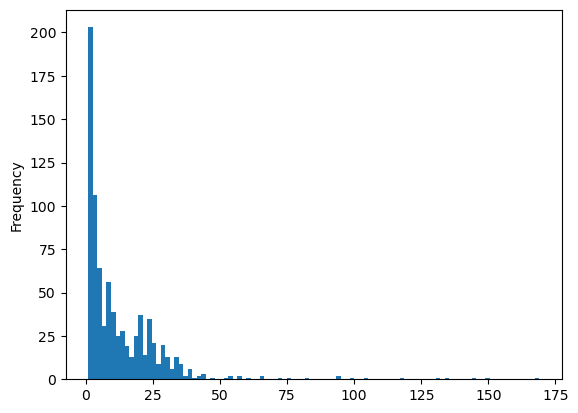

In [18]:
# Target distribution
train_df['count'].value_counts().plot.hist(bins=100)

In [19]:
# Drop unused columns
train_df = train_df.drop(['casual', 'registered'], axis=1)

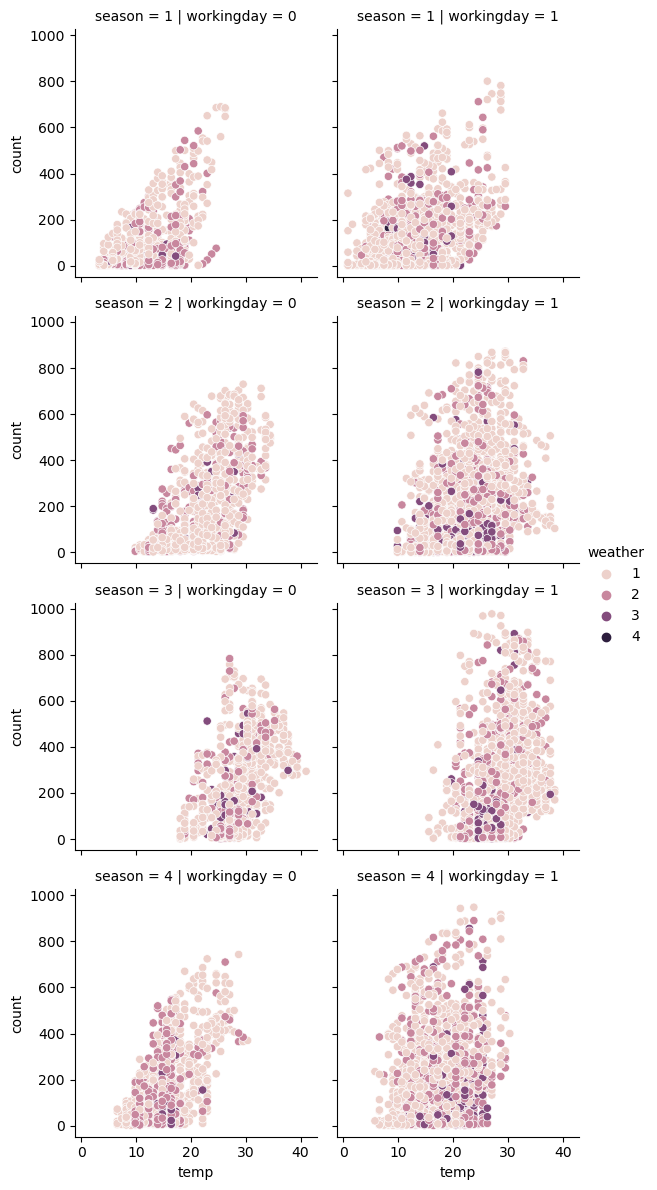

In [20]:
# Dependency plot between temp and target variable prior to weather, season and workingday
sns.relplot(
    data=train_df,
    x="temp", y="count", hue="weather",
    col="workingday", row="season", height=3
)

In [21]:
# Lets extract year, month and day from date as features

def get_features(df):
    df['year'] = df.datetime.apply(lambda x: x.year)
    df['month'] = df.datetime.apply(lambda x: x.month)
    df['day'] = df.datetime.apply(lambda x: x.day)
    df['hour'] = df.datetime.apply(lambda x: x.hour)
    df['weekday'] = df.datetime.dt.day_name()
    return df

train_df = get_features(train_df)
test_df = get_features(test_df)

In [22]:
cat_features = ["weather", "season", "weekday"]

for feature in cat_features:
    train_df[feature] = train_df[feature].astype('category')
    test_df[feature] = test_df[feature].astype('category')

In [23]:
# Split data into train and test

from sklearn.model_selection import train_test_split

X = train_df.drop(['datetime', 'count'], axis=1)
y = train_df['count']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
model = Pipeline([
    ('onehot', make_column_transformer(
      (OneHotEncoder(), cat_features),
    remainder='passthrough')),
    ('clf', RandomForestRegressor())
])
model.fit(X_train, y_train)

Pipeline(steps=[('onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['weather', 'season',
                                                   'weekday'])])),
                ('clf', RandomForestRegressor())])

Text(0.5, 1.0, 'Validation real/pred plot | RMSE = 39.2090677766468')

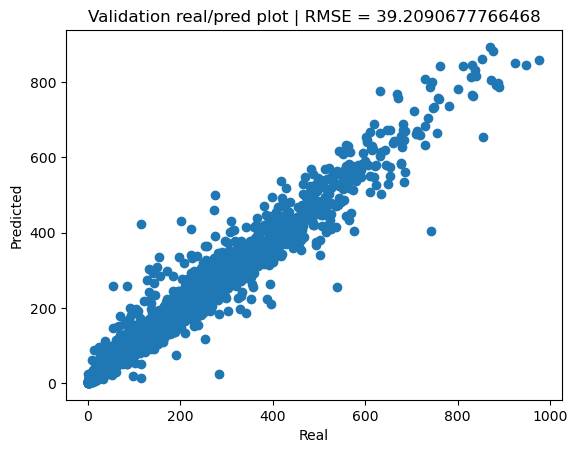

In [25]:
plt.scatter(y_val, model.predict(X_val))
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title(f"Validation real/pred plot | RMSE = {np.sqrt(mean_squared_error(y_val, model.predict(X_val)))}")

Text(0.5, 1.0, 'Train real/pred plot | RMSE = 15.320352186278926')

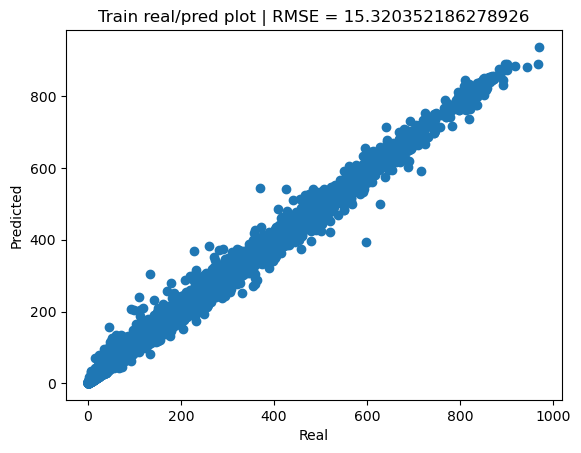

In [26]:

plt.scatter(y_train, model.predict(X_train))
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title(f"Train real/pred plot | RMSE = {np.sqrt(mean_squared_error(y_train, model.predict(X_train)))}")

In [62]:
predicts_test = model.predict(test_df.drop('datetime', axis=1))
test_df['count'] = predicts_test
test_df['count'].loc[test_df['count'] < 0] = 0

test_df[['datetime', 'count']].to_csv('../data/test_res.csv', header=True, index=False)

/var/folders/zc/656lf64j5fq147szr_4d4t500000gp/T/ipykernel_87779/745290928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['count'].loc[test_df['count'] < 0] = 0
